In [1]:
# Import the Library
import numpy as np # linear algebra
import cv2 
import matplotlib.pyplot as plt # make plots
import os
import xml.etree.ElementTree as ET
from sklearn.model_selection import train_test_split
from PIL import Image

In [2]:
# Path of Images and Annotation
Annotation_dir = './stanford-dogs-dataset/annotations/Annotation/'
Image_dir = './stanford-dogs-dataset/images/Images/'

# list of breeds of dogs in the dataset
breed_list = os.listdir(Image_dir)

# Find Number of Classes
num_classes = len(breed_list)
print("Number of Classes is : ", num_classes)

## set the seed for the np.random module, so we always get the same image when run this code cell
np.random.seed(35)

total_no_images = 0

for breed in breed_list:
    total_no_images += len(os.listdir(Image_dir+"{}/".format(breed)))

print("Number of Images is :", total_no_images)


Number of Classes is :  120
Number of Images is : 20580


In [3]:
# Convert String lable into numbers
label_maps = {}
label_maps_rev = {}
for i, v in enumerate(breed_list):
    label_maps.update({v: i})
    label_maps_rev.update({i : v})

In [4]:
# label_maps_rev

## Display some Image of class 1

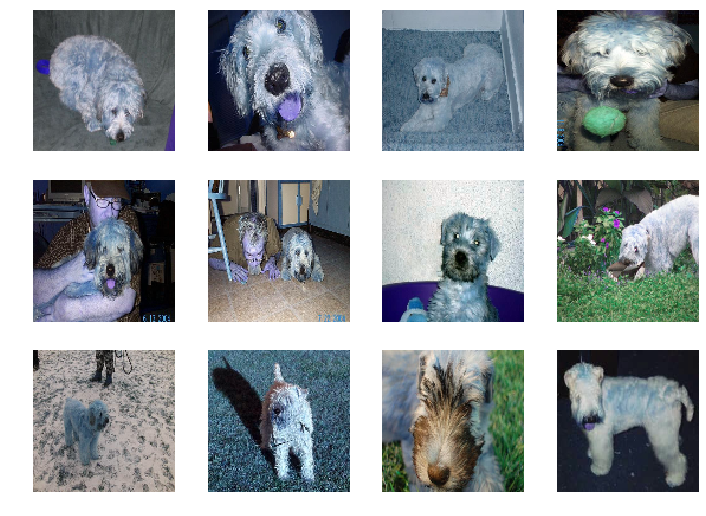

In [5]:
# Display 12 Images of class 1
display_img = 12
img_dir = Image_dir+"{}/".format(breed_list[1])
image = os.listdir(img_dir)[:display_img]
plt.figure(figsize=(12,12))
for im in range(display_img):
    img = cv2.imread(img_dir+image[im], 1)
    img = cv2.resize(img, (120,120))
    plt.subplot(display_img/4+1, 4, im+1)
    plt.imshow(img)
    plt.axis('off')
    

## Crop Image using Bounding Box from Annotation_dir

In [6]:
# initialization of variables
img_path = list()
img_lable = list()
class_name = list()
images = list()
img_size = 160

# Make image data directory for save crop images
if not os.path.exists('img_data'):
    os.mkdir('img_data')

# Read list of Annotation and Image dir for getting bounding box and images to crop
for breed in breed_list:
    for file in os.listdir(Annotation_dir+"{}/".format(breed)):
        # read image using Image path
        img = Image.open(Image_dir+'{}/{}.jpg'.format(breed, file))
        # Annotation dir path
        tree = ET.parse(Annotation_dir+'/{}/{}'.format(breed, file))
        # Read the class name
        name = str(tree.getroot().findall('object')[0].find('name').text)
        # read bounding box values
        xmin = int(tree.getroot().findall('object')[0].find('bndbox').find('xmin').text)
        xmax = int(tree.getroot().findall('object')[0].find('bndbox').find('xmax').text)
        ymin = int(tree.getroot().findall('object')[0].find('bndbox').find('ymin').text)
        ymax = int(tree.getroot().findall('object')[0].find('bndbox').find('ymax').text)
        
        img = img.crop((xmin, ymin, xmax, ymax)) # crop image 
        img = img.convert('RGB') # convert image to RGB Channel
        resized_img = img.resize((img_size, img_size))  # resize image 160 * 160
        
        # make Classwise folder into img_data folder
        if not os.path.exists('./img_data/' + breed):
            os.mkdir('./img_data/' + breed)
        
        img.save('./img_data/' + breed + '/' + file + '.jpg') # Save image into class folder
        images.append(np.array(resized_img)) # store resize image into list
        img_lable.append(label_maps[breed])  # store class lable into list
        class_name.append(name)
        img_path.append('./img_data/' + breed + '/' + file + '.jpg')
        

# After Crop Images

./img_data/n02098105-soft-coated_wheaten_terrier/


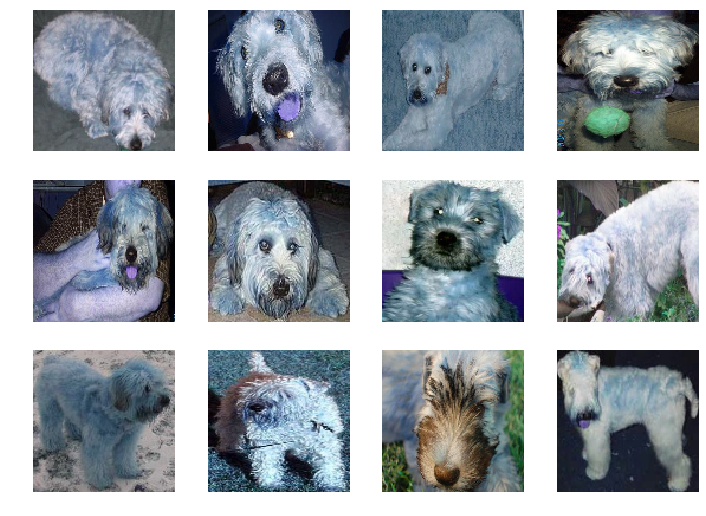

In [7]:
# Display crop Images
display_img = 12
img_dir = "./img_data/{}/".format(breed_list[1])
image = os.listdir(img_dir)[:display_img]
print(img_dir)
plt.figure(figsize=(12,12))
for im in range(display_img):
    img = cv2.imread(img_dir+image[im], 1)
    img = cv2.resize(img, (120,120))
    plt.subplot(display_img/4+1, 4, im+1)
    plt.imshow(img)
    plt.axis('off')

In [8]:
# Create one hot encoding and normalize image data
from keras.utils import to_categorical
images = np.array(images)
labels = y = to_categorical(np.array(img_lable))

print("Images shape = ",images.shape,"\nLabels shape = ",labels.shape)
print(type(images),type(img_lable))

Using TensorFlow backend.


Images shape =  (20580, 160, 160, 3) 
Labels shape =  (20580, 120)
<class 'numpy.ndarray'> <class 'list'>


## Data Normalization

In [ ]:
# import tensorflow as tf
# from keras.utils import to_categorical

images = images.astype(np.float32)
# label = to_categorical(img_lable)
images = images/255
print("Images shape after normalization = ",images.shape)

Images shape after normalization =  (20580, 160, 160, 3)


# Split data into train and test set

In [ ]:

x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size = 0.2, random_state = 42)

print("x_train shape = ",x_train.shape)
print("y_train shape = ",y_train.shape)
print("\nx_test shape = ",x_test.shape)
print("y_test shape = ",y_test.shape)

x_train shape =  (16464, 160, 160, 3)
y_train shape =  (16464, 120)

x_test shape =  (4116, 160, 160, 3)
y_test shape =  (4116, 120)


# make CNN model 

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
import keras 
import tensorflow as tf
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

config = tf.ConfigProto( device_count = {'GPU': 1 , 'CPU': 8} ) 
sess = tf.Session(config=config) 
keras.backend.set_session(sess)


input_shape = (img_size, img_size, 3)

model = Sequential()
model.add(Conv2D(64, kernel_size=(11, 11), activation='relu', input_shape=input_shape))
model.add(BatchNormalization())

model.add(Conv2D(128, kernel_size=(7, 7), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))

model.add(Conv2D(256, kernel_size=(5, 5), activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(1024, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

print(model.summary())

W0201 10:21:20.640445 140550991980352 deprecation_wrapper.py:119] From /home/manotr/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0201 10:21:20.641089 140550991980352 deprecation_wrapper.py:119] From /home/manotr/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W0201 10:21:20.641503 140550991980352 deprecation_wrapper.py:119] From /home/manotr/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:186: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.

W0201 10:21:20.686980 140550991980352 deprecation_wrapper.py:119] From /home/manotr/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:190: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 150, 150, 64)      23296     
_________________________________________________________________
batch_normalization_1 (Batch (None, 150, 150, 64)      256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 144, 144, 128)     401536    
_________________________________________________________________
batch_normalization_2 (Batch (None, 144, 144, 128)     512       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 48, 48, 128)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 48, 48, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 44, 44, 256)       819456    
__________

In [ ]:
# Train the model
history = model.fit(x_train, y_train, epochs=100, validation_split=0.33, batch_size=64)

W0201 10:21:21.183995 140550991980352 deprecation.py:323] From /home/manotr/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 11030 samples, validate on 5434 samples
Epoch 1/100
11030/11030 [==============================] - 2188s 198ms/step - loss: 5.3967 - acc: 0.0240 - val_loss: 5.0501 - val_acc: 0.0383
Epoch 2/100
11030/11030 [==============================] - 2190s 199ms/step - loss: 4.8082 - acc: 0.0384 - val_loss: 4.5471 - val_acc: 0.0464
Epoch 3/100
 1728/11030 [===>..........................] - ETA: 27:53 - loss: 4.4466 - acc: 0.0631

In [ ]:
# Test Model
score = model.evaluate(x_test, y_test, batch_size=16)

## Plot training & validation accuracy values 

In [ ]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()